In [1]:
pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
pip install accelerate -U

### ***Implementing Bert for Q & A***

In [13]:
import torch
from transformers import BertTokenizer, BertForQuestionAnswering
import json
from collections import defaultdict
import ipywidgets as widgets
from IPython.display import display, HTML
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# Load the tokenizer and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad').to(device)

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)['data']
    return data

def find_relevant_context(question, contexts):
    best_context = None
    max_score = float('-inf')
    for context in contexts:
        inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors='pt', truncation=True, padding=True, max_length=512)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        score = (outputs.start_logits + outputs.end_logits).max().item()
        if score > max_score:
            max_score = score
            best_context = context
    return best_context

def answer_question(question, context):
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors='pt', max_length=512, truncation=True, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    answer_start = torch.argmax(outputs.start_logits)
    answer_end = torch.argmax(outputs.end_logits) + 1
    answer = tokenizer.decode(input_ids[0][answer_start:answer_end], skip_special_tokens=True)
    return answer

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ***UI to input question and display answer and context***

In [16]:
# Load data and define titles
data = load_data('/content/dev.json')
titles = [article['title'] for article in data]

# Function to handle question input and display answer and context
def ask_question(title_idx, question):
    selected_title = titles[title_idx]
    title_to_contexts = {article['title']: [para['context'] for para in article['paragraphs']] for article in data}
    relevant_context = find_relevant_context(question, title_to_contexts[selected_title])
    if relevant_context:
        answer = answer_question(question, relevant_context)
        answer_output.value = f"<div style='background-color: #9ACD32; padding: 10px; border-radius: 5px;'>Answer: {answer}</div>"
        context_output.value = f"<div style='background-color: #ADD8E6; padding: 10px; border-radius: 5px;'>Context: {relevant_context}</div>"
    else:
        answer_output.value = "<div style='color: red;'>Sorry, could not find a relevant context for your question.</div>"
        context_output.value = ""

    # Clear previous answer and context
    question_input.value = ""
    answer_output.layout.visibility = 'visible'
    context_output.layout.visibility = 'visible'

# Create dropdown widget for selecting title
title_dropdown = widgets.Dropdown(
    options=[(f"{idx + 1}: {title}", idx) for idx, title in enumerate(titles)],
    description='Titles:'
)

# Create text input widget for entering question
question_input = widgets.Text(
    placeholder='Enter your question here',
    description='Question:'
)

# Create output widgets for displaying answer and context
answer_output = widgets.HTML()
context_output = widgets.HTML()

# Function to handle question submission
def on_submit_button_clicked(b):
    title_idx = title_dropdown.value
    question = question_input.value
    ask_question(title_idx, question)

# Create submit button
submit_button = widgets.Button(description='Submit', style={'button_color': 'lightgreen'})
submit_button.on_click(on_submit_button_clicked)

# Arrange widgets in a vertical box
ui = widgets.VBox([title_dropdown, question_input, submit_button, answer_output, context_output])

# Apply styling to widgets
ui.layout.margin = '50px auto'
ui.layout.padding = '20px'
ui.layout.border = '2px solid #FF6347'
title_dropdown.layout.width = '50%'
question_input.layout.width = '50%'
submit_button.layout.width = '20%'
submit_button.layout.margin = '20px 0 0 0'
answer_output.layout.margin = '20px 0 0 0'
context_output.layout.margin = '20px 0 0 0'

# Display UI
display(ui)

### ***Evaluation***

In [5]:
# Normalize answer function
def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punctuation(text):
        return ''.join(c for c in text if c not in set(string.punctuation))
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punctuation(lower(s))))

# Compute Exact Match function
def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

# Compute F1 score function
def compute_f1(a_gold, a_pred):
    gold_toks = normalize_answer(a_gold).split()
    pred_toks = normalize_answer(a_pred).split()
    common = set(gold_toks) & set(pred_toks)
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        return int(gold_toks == pred_toks)
    precision = len(common) / len(pred_toks)
    recall = len(common) / len(gold_toks)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Load the tokenizer and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad').to(device)

# Load data function
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)['data']
    return data

# Find relevant context function
def find_relevant_context(question, contexts, model, tokenizer, device):
    best_context = None
    max_score = float('-inf')
    for context in contexts:
        inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors='pt', truncation=True, padding=True, max_length=512)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        score = (outputs.start_logits + outputs.end_logits).max().item()
        if score > max_score:
            max_score = score
            best_context = context
    return best_context

# Answer question function
def answer_question(question, context, model, tokenizer, device):
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors='pt', max_length=512, truncation=True, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    answer_start = torch.argmax(outputs.start_logits)
    answer_end = torch.argmax(outputs.end_logits) + 1
    answer = tokenizer.decode(input_ids[0][answer_start:answer_end], skip_special_tokens=True)
    return answer

# Evaluate model function
def evaluate_model(data, model, tokenizer, device):
    f1 = exact_match = total = 0
    for article in data:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                total += 1
                question = qa['question']
                true_answer = qa['answers'][0]['text']
                predicted_answer = answer_question(question, context, model, tokenizer, device)
                exact_match += compute_exact(true_answer, predicted_answer)
                f1 += compute_f1(true_answer, predicted_answer)
    exact_match = exact_match / total
    f1 = f1 / total
    return {'exact_match': exact_match, 'f1': f1}

# Main interaction function
def main():
    data = load_data('/content/dev.json')
    evaluation_results = evaluate_model(data, model, tokenizer, device)
    print("Evaluation results:", evaluation_results)

if __name__ == '__main__':
    main()

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluation results: {'exact_match': 0.231, 'f1': 0.3407089991930131}


## ***EDA***

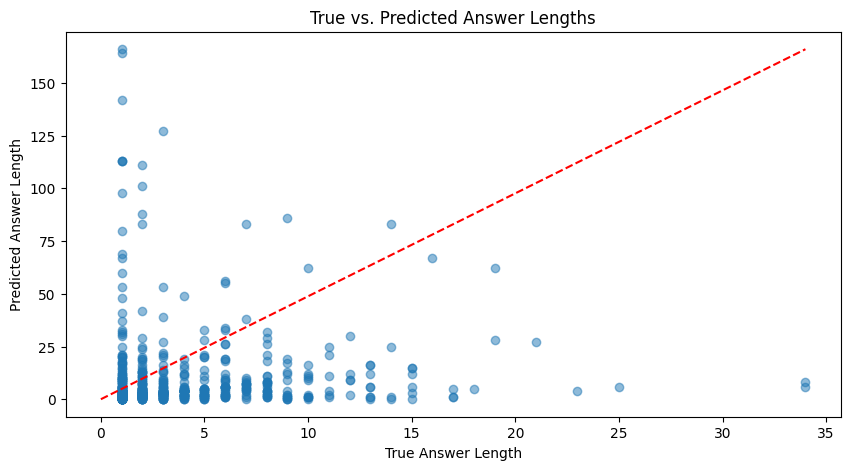

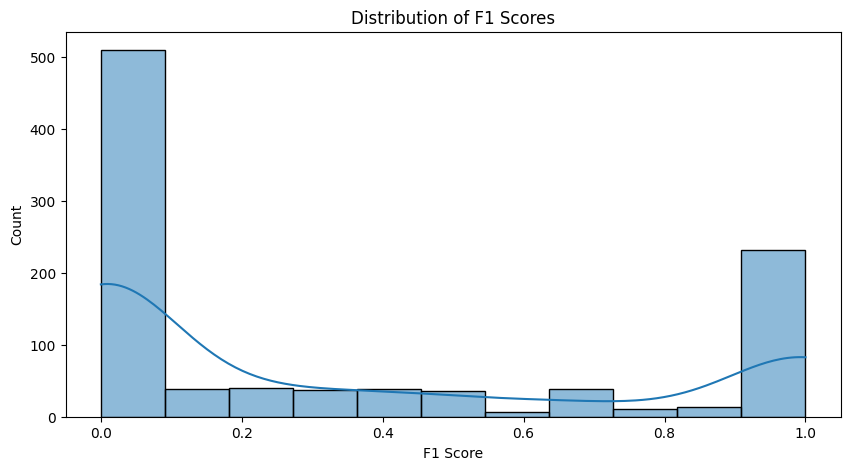

In [6]:
def evaluate_model(data, model, tokenizer, device):
    exact_match, f1 = 0, 0
    true_answers, predicted_answers = [], []

    for article in data:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                context = paragraph['context']
                question = qa['question']
                true_answer = qa['answers'][0]['text']

                # Pass model, tokenizer, and device arguments to answer_question function
                predicted_answer = answer_question(question, context, model, tokenizer, device)

                true_answers.append(true_answer)
                predicted_answers.append(predicted_answer)

                exact_match += compute_exact(true_answer, predicted_answer)
                f1 += compute_f1(true_answer, predicted_answer)

    return {
        'exact_match': exact_match / len(true_answers),
        'f1': f1 / len(true_answers),
        'true_answers': true_answers,
        'predicted_answers': predicted_answers
    }
# Example usage after you've run the evaluation
evaluation_results = evaluate_model(data, model, tokenizer, device)

# Extract lists for visualization
true_answers = evaluation_results['true_answers']
predicted_answers = evaluation_results['predicted_answers']

# Length comparison
true_answer_lengths = [len(ans.split()) for ans in true_answers]
predicted_answer_lengths = [len(ans.split()) for ans in predicted_answers]

plt.figure(figsize=(10, 5))
plt.scatter(true_answer_lengths, predicted_answer_lengths, alpha=0.5)
plt.xlabel('True Answer Length')
plt.ylabel('Predicted Answer Length')
plt.title('True vs. Predicted Answer Lengths')
plt.plot([0, max(true_answer_lengths)], [0, max(predicted_answer_lengths)], 'r--')  # Diagonal line
plt.show()

# F1 Score distribution
f1_scores = [compute_f1(ta, pa) for ta, pa in zip(true_answers, predicted_answers)]
plt.figure(figsize=(10, 5))
sns.histplot(f1_scores, kde=True)
plt.title('Distribution of F1 Scores')
plt.xlabel('F1 Score')
plt.show()

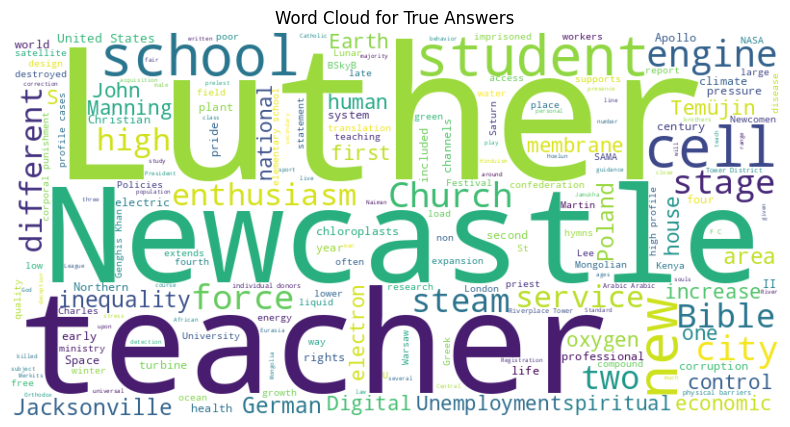

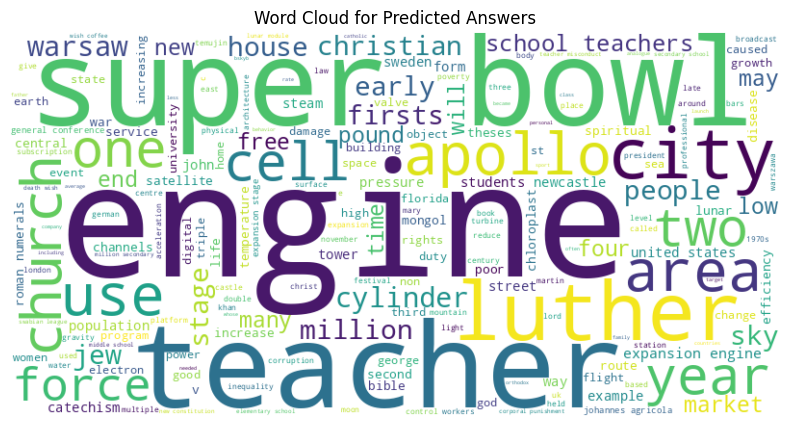

In [7]:
# Function to generate word cloud from a list of text
def generate_word_cloud(text_list, title):
    # Concatenate all text in the list
    text = ' '.join(text_list)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word cloud for true answers
generate_word_cloud(true_answers, 'Word Cloud for True Answers')

# Generate word cloud for predicted answers
generate_word_cloud(predicted_answers, 'Word Cloud for Predicted Answers')

In [8]:
import json

# Load the data
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)['data']
    return data

# Path to your dataset
file_path = '/content/dev.json'
data = load_data(file_path)

# Basic Data Overview
num_articles = len(data)
num_paragraphs = sum(len(article['paragraphs']) for article in data)
num_questions = sum(len(para['qas']) for article in data for para in article['paragraphs'])

print(f"Total number of articles: {num_articles}")
print(f"Total number of paragraphs: {num_paragraphs}")
print(f"Total number of questions: {num_questions}")

Total number of articles: 21
Total number of paragraphs: 283
Total number of questions: 1000


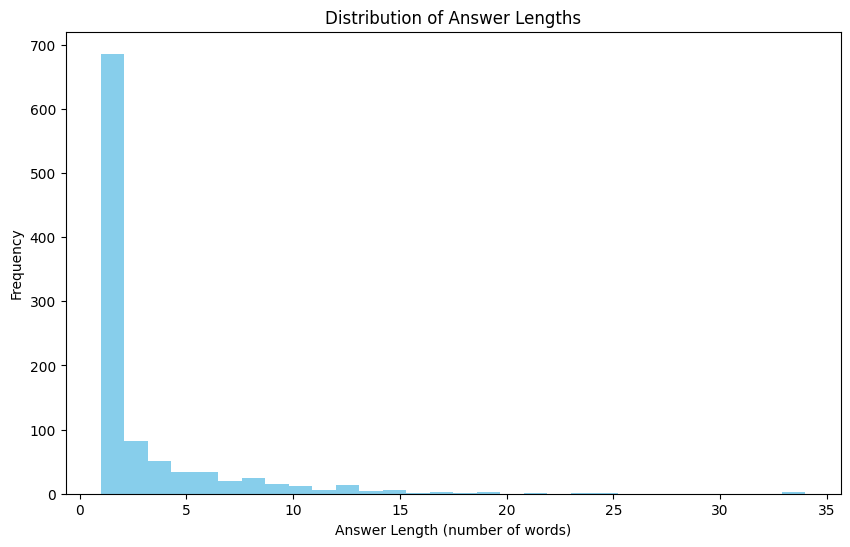

In [9]:
import matplotlib.pyplot as plt

# Extracting answer lengths
answer_lengths = []
for article in data:
    for paragraph in article['paragraphs']:
        for qa in paragraph['qas']:
            answer_text = qa['answers'][0]['text']
            # Split the answer into words and count them
            answer_lengths.append(len(answer_text.split()))

# Plotting the distribution of answer lengths
plt.figure(figsize=(10, 6))
plt.hist(answer_lengths, bins=30, color='skyblue')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Answer Length (number of words)')
plt.ylabel('Frequency')
plt.show()

In [10]:
from collections import Counter

# Categorizing questions based on their starting word
question_starts = Counter()
for article in data:
    for paragraph in article['paragraphs']:
        for qa in paragraph['qas']:
            question = qa['question'].split()[0]  # Get the first word
            question_starts[question] += 1

# Display the most common question starts
print(question_starts.most_common(10))

[('What', 410), ('Which', 123), ('Who', 80), ('what', 68), ('How', 57), ('Where', 39), ('The', 32), ('Why', 17), ('In', 13), ('When', 10)]


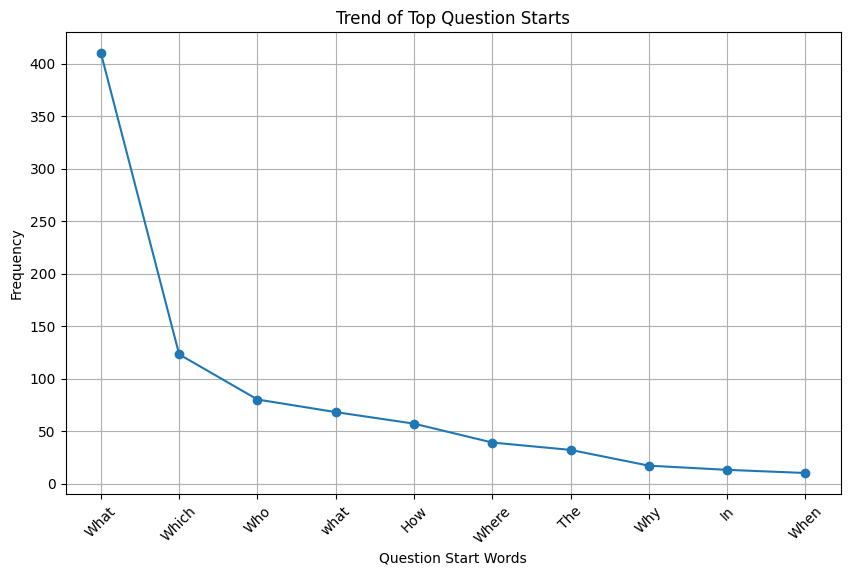

In [11]:
# Assuming question_starts is already calculated
top_question_starts = question_starts.most_common(10)
words, frequencies = zip(*top_question_starts)

plt.figure(figsize=(10, 6))
plt.plot(words, frequencies, marker='o')
plt.title('Trend of Top Question Starts')
plt.xlabel('Question Start Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

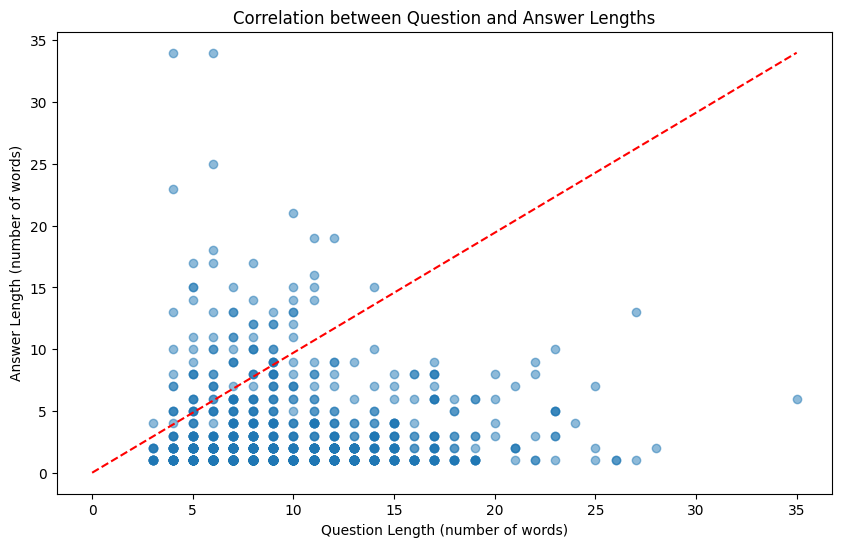

In [12]:
question_lengths = []
for article in data:
    for paragraph in article['paragraphs']:
        for qa in paragraph['qas']:
            question = qa['question']
            question_lengths.append(len(question.split()))

# Scatter plot of question vs answer lengths
plt.figure(figsize=(10, 6))
plt.scatter(question_lengths, answer_lengths, alpha=0.5)
plt.xlabel('Question Length (number of words)')
plt.ylabel('Answer Length (number of words)')
plt.title('Correlation between Question and Answer Lengths')
plt.plot([0, max(question_lengths)], [0, max(answer_lengths)], 'r--')  # Add a reference line
plt.show()